In [1]:
%cd ..

/Users/heilman/galvanize/recipe-vectorizer


In [16]:
from src.functions import *
from src.modeling_functions import *
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter
from string import *
from sklearn.metrics.pairwise import cosine_similarity
from sys import argv, exit
import pymongo
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

In [26]:
search_term = 'soup'
n_recipes = 12

min_cluster_size = 8

mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

print('Searching for {} recipes...'.format(search_term))
recipes, ratings = find_recipes_matching_search(recipes_coll, search_term)
print('{} recipes found.'.format(len(recipes)))

df = create_dataframe(recipes)
X = df.values
cosine_sims = cosine_similarity(X)

G = create_graph(cosine_sims, threshold=0.8)
remove_isolates(G, min_cluster_size)

graphs = [G.copy()]
n_subgraphs = nx.number_connected_components(G)
print('{} clusters identified.'.format(n_subgraphs))
while n_subgraphs < n_recipes:
    largest_subgraph = max(nx.connected_component_subgraphs(G), key=len)
    graphs += split_subgraph(largest_subgraph, G, return_history=True)
    remove_isolates(G, min_cluster_size)
    new_n = nx.number_connected_components(G)
    if n_subgraphs < new_n:
        print('{} clusters identified.'.format(new_n))
    n_subgraphs = new_n
    if len(G) <= min_cluster_size:
        break

recipe_names_in_cluster = []
for component in nx.connected_components(G):
    recipe_names_in_cluster.append(get_recipe_names(component, df.index, recipes))

cluster_keywords = []
for names in recipe_names_in_cluster:
    cluster_keywords.append(find_keywords(names, limit=4))

recipe_results = generate_recipes(G, df)

for i, r in enumerate(recipe_results):
    print('\nRecipes in cluster (5 of {}) :'.format(len(recipe_names_in_cluster[i])))
    print(recipe_names_in_cluster[i][:5])
    print('\nCluster keywords :')
    print(cluster_keywords[i])
    print('\nSuggested recipe :')
    print(r)
    print('--------------------------------')

Searching for soup recipes...
567 recipes found.
1 clusters identified.
2 clusters identified.
3 clusters identified.
4 clusters identified.
5 clusters identified.
6 clusters identified.
7 clusters identified.
8 clusters identified.
9 clusters identified.
10 clusters identified.
11 clusters identified.
12 clusters identified.

Recipes in cluster (5 of 10) :
["John's Chili", "Chad's Slow Cooker Taco Soup", 'Chicken Chili Soup', 'Taco Soup VI', 'Taco Soup I']

Cluster keywords :
[('soup', 9), ('taco', 7), ('chili', 2), ('slow', 2)]

Suggested recipe :
tomato                3.216748
onion                 0.666442
beef                  2.045612
kidney beans          2.415387
taco seasoning mix    0.139248
water                 0.859508
corn                  0.837971
bell pepper           0.520196
tomato sauce          0.480722
green chile           0.137790
chili powder          0.012318
cheddar cheese        0.147347
sour cream            0.147347
black beans           0.446418
garlic    

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

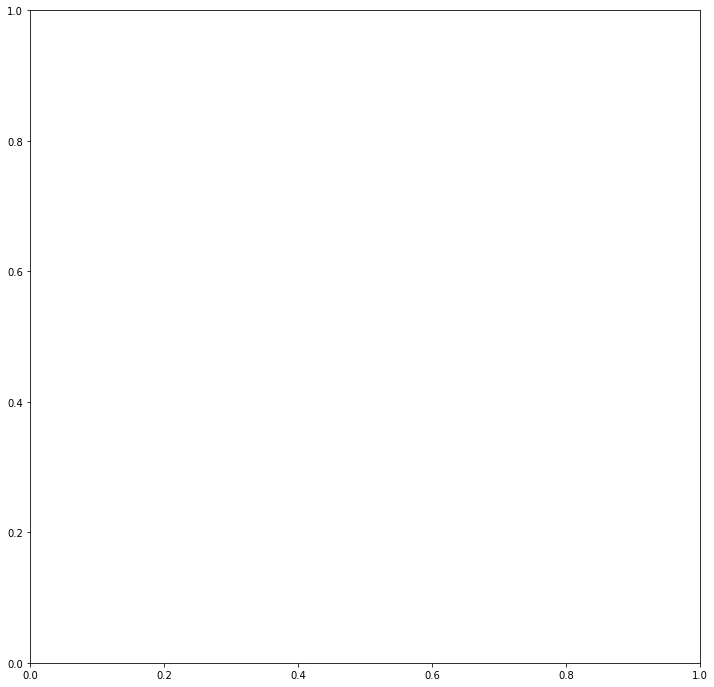

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
plot_weighted_graph(graphs[795], ax, k=0.5, fixed_axes=(-1.00, 1.00, -1, 1))
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

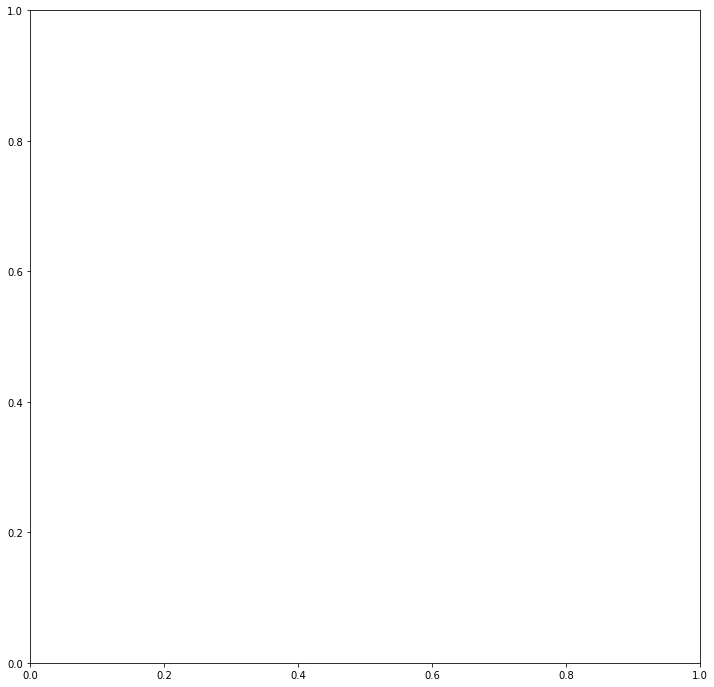

In [27]:
#frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i,graph in enumerate(graphs):
    pct = int((i/len(graphs)) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=(12,12))
    plot_weighted_graph(graph, ax, k=0.5, fixed_axes=(-1.00, 1.00, -1, 1))
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    pct = int(((i+1)/len(graphs)) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
imageio.mimsave('images/soup-12-clusters.gif', frames, duration=0.1)

In [32]:
imageio.mimsave('images/soup-12-clusters-incomplete.gif', frames, duration=0.1)

In [28]:
len(frames)

794

In [29]:
len(graphs)

1105